#**Emotion Recognition for Sentiment Analysis**

## Public Avaliable Dataset

####**CK+ dataset**
Dataset Overview:
* The CK+ dataset consists of 593 video clips from 123 participants aged 18 to 50 years.
* Each video sequence begins with a neutral face expression and escalates to the highest representation of one of seven basic emotions: anger, contempt, disgust, fear, happiness, sadness, neutral and surprise.
* The dataset contains both grayscale and color images, with each frame measuring 640x490 pixels in size.
* The images have been annotated with the locations of 68 facial landmarks, which can be utilized for facial expression analysis and alignment.
* The dataset is separated into three subsets: training, public test, and private testing.

</t>The CSV file has the following columns: <br>

* Emotion: Integer value representing emotion label (0: Anger, 1:Disgust, 2: Fear, 3: Happiness, 4: Sadness, 5: Surprise, 6: Neutral, 7: Contempt).
* pixels: String of pixels values separated by spaces, representing the grayscale pixel values of 48x48 image.
* usage: String indicating subset image belongs to (Training, PrivateTest, or PublicTest).

Download from: https://www.kaggle.com/datasets/davilsena/ckdataset

#Experimental Steps:

1. Download required libraries, dataset and landmark files
2. Import required libraries
3. Run all bellows cells:
    * Step 1: Data Loading
        * Simple Eda
    * Step 2: Feature Extraction Functions
    * Step 3: Experiment Function
    * Step 4: Visualization Functions
    * Step 5: Main Experiment (change here for dataset path and params change for selected features)
4. Analysis



#Download required libraries, dataset and landmark files

In [ ]:
# copy the dataset csv file of ckextended in same directory as this notebook

In [ ]:
# Download shape_predictor_68_face_landmarks
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

--2024-07-06 17:02:50--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  47.0MB/s    in 1.3s    

2024-07-06 17:02:52 (47.0 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

bzip2: Output file shape_predictor_68_face_landmarks.dat already exists.


In [ ]:
# Requirement installation if required, not needed in Colab (pre-installed everything)

!pip install dlib
!pip install scikit-image
!pip install scikit-learn
!pip install seaborn
!pip install opencv-python
!pip install matplotlib
!pip install scipy
!pip install pandas
!pip install numpy

# Import required libraries

In [ ]:
import cv2
import dlib
import numpy as np
import pandas as pd
from scipy.spatial import distance
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


warnings.filterwarnings('ignore')

# Step 1: Data Loading

In [ ]:
# data generation for classifier and feature extracion
def load_dataset(data):
    """
    Data generation from a dataframe which have fer2013 dataset supported formati.e. having column [Emotion,Pixels, Usage] .

    Args:
    Data (dataframe): Dataframe of dataset.

    Returns:
    tuple: (X, y) where X is the image data and y is the emotion labels.
    """
    try:
        X = np.array([np.array(row['pixels'].split(' '), dtype='uint8').reshape(48, 48) for _, row in data.iterrows()])
        y = np.array(data['emotion'])
        return X, y

    except Exception as e:
        print(f"Error loading dataset: {str(e)}")
        return None, None

### Simple EDA

In [ ]:
def perform_eda(data, label_to_emotion):
    """
    Perform basic Exploratory Data Analysis on the dataset.
    """
    emotion_labels = list(label_to_emotion.values())

    print("\n--- Dataset Information ---")
    print(f"\t loaded dataset data points:")
    display(data[:5])
    print(f"\tTotal number of samples: {len(data)}")
    print("\nEmotion distribution:")
    emotion_counts = data['emotion'].map(label_to_emotion).value_counts()
    print(emotion_counts)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
    plt.title('Distribution of Emotions in the Dataset')
    plt.xlabel('Emotion Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

    print("\nSample image:")
    sample_image = np.array(data.iloc[0]['pixels'].split(' '), dtype='uint8').reshape(48, 48)
    plt.imshow(sample_image, cmap='gray')
    plt.title(f"Emotion: {label_to_emotion[data.iloc[0]['emotion']]}")
    plt.axis('off')
    plt.show()

# Step 2: Feature Extraction Functions

In [ ]:
def extract_hog_features(image, win_size, block_size, block_stride, cell_size, nbins):
    """
    Extract Histogram of Oriented Gradients (HOG) features from an image.

    Args:
    image (numpy.ndarray): Input image.
    win_size, block_size, block_stride, cell_size, nbins: HOG parameters.

    Returns:
    numpy.ndarray: Flattened HOG features.
    """
    try:
        if image.shape[:2] != win_size:
            image = cv2.resize(image, win_size)
        hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
        hog_features = hog.compute(image)
        if isinstance(hog_features, tuple):
            hog_features = hog_features[0] if len(hog_features) > 0 else np.zeros((nbins * (win_size[0] // cell_size[0] - 1) * (win_size[1] // cell_size[1] - 1),))
        return np.array(hog_features).flatten()

    except Exception as e:
        print(f"Error extracting HOG features: {str(e)}")
        return np.array([])

def extract_facial_landmarks(image, predictor):
    """
    Extract facial landmarks using dlib's face landmark predictor.

    Args:
    image (numpy.ndarray): Input image.
    predictor: dlib's face landmark predictor.

    Returns:
    numpy.ndarray: Array of facial landmark coordinates.
    """
    try:
        resized_image = cv2.resize(image, (48, 48))
        face_rect = dlib.rectangle(0, 0, resized_image.shape[1], resized_image.shape[0])
        landmarks = predictor(resized_image, face_rect)
        return np.array([[p.x, p.y] for p in landmarks.parts()])

    except Exception as e:
        print(f"Error extracting facial landmarks: {str(e)}")
        return np.array([])

def extract_lbp_features(image, radius, n_points, method):
    """
    Extract Local Binary Pattern (LBP) features from an image.

    Args:
    image (numpy.ndarray): Input image.
    radius, n_points, method: LBP parameters.

    Returns:
    numpy.ndarray: LBP histogram features.
    """
    try:
        lbp = local_binary_pattern(image, n_points, radius, method=method)
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        return hist.astype("float") / (hist.sum() + 1e-7)

    except Exception as e:
        print(f"Error extracting LBP features: {str(e)}")
        return np.array([])

def extract_texture_features(image, distances, angles, props):
    """
    Extract texture features using Gray-Level Co-Occurrence Matrix (GLCM).

    Args:
    image (numpy.ndarray): Input image.
    distances, angles, props: GLCM parameters.

    Returns:
    numpy.ndarray: Texture features.
    """
    try:
        glcm = graycomatrix(image, distances, angles, symmetric=True, normed=True)
        return np.array([graycoprops(glcm, prop).ravel() for prop in props]).flatten()

    except Exception as e:
        print(f"Error extracting texture features: {str(e)}")
        return np.array([])

def extract_geometry_features(landmarks):
    """
    Extract geometric features from facial landmarks.

    Args:
    landmarks (numpy.ndarray): Array of facial landmark coordinates.

    Returns:
    list: Geometric features.
    """
    try:
        left_eye = np.mean(landmarks[36:42], axis=0)
        right_eye = np.mean(landmarks[42:48], axis=0)
        nose = landmarks[30]
        left_mouth, right_mouth = landmarks[48], landmarks[54]

        eye_distance = distance.euclidean(left_eye, right_eye)
        nose_mouth_distance = distance.euclidean(nose, np.mean([left_mouth, right_mouth], axis=0))
        mouth_width = distance.euclidean(left_mouth, right_mouth)

        eye_nose_ratio = eye_distance / distance.euclidean(left_eye, nose)
        eye_mouth_ratio = eye_distance / mouth_width
        nose_mouth_ratio = nose_mouth_distance / mouth_width

        return [eye_distance, nose_mouth_distance, mouth_width, eye_nose_ratio, eye_mouth_ratio, nose_mouth_ratio]

    except Exception as e:
        print(f"Error extracting geometry features: {str(e)}")
        return []

def extract_temporal_features(prev_features, curr_features):
    """
    Extract temporal features by comparing current features with previous features.

    Args:
    prev_features (numpy.ndarray): Features from the previous frame.
    curr_features (numpy.ndarray): Features from the current frame.

    Returns:
    numpy.ndarray: Temporal features.
    """
    try:
        return np.zeros_like(curr_features) if prev_features is None or prev_features.shape != curr_features.shape else curr_features - prev_features

    except Exception as e:
        print(f"Error extracting temporal features: {str(e)}")
        return np.array([])


In [ ]:
def extract_features(image, predictor, prev_features=None, hog_params=None, lbp_params=None, texture_params=None):
    """
    Extract all features from an image.

    Args:
    image (numpy.ndarray): Input image.
    predictor: dlib's face landmark predictor.
    prev_features, hog_params, lbp_params, texture_params: Parameters for feature extraction.

    Returns:
    numpy.ndarray: Combined feature vector.
    """
    try:
        hog_features = extract_hog_features(image, **hog_params)
        lbp_features = extract_lbp_features(image, **lbp_params)
        landmarks = extract_facial_landmarks(image, predictor)
        geometry_features = extract_geometry_features(landmarks)
        texture_features = extract_texture_features(image, **texture_params)

        features = np.concatenate((hog_features, lbp_features, geometry_features, texture_features))
        temporal_features = extract_temporal_features(prev_features, features)
        return np.concatenate((features, temporal_features))

    except Exception as e:
        print(f"Error extracting features: {str(e)}")
        return np.array([])

# Step 3: Experiment Function

In [ ]:
def run_experiment(X, y, predictor, hog_params, lbp_params, texture_params):
    """
    Run a single experiment with given parameters.

    Args:
    X, y: Input data and labels.
    predictor: dlib's face landmark predictor.
    hog_params, lbp_params, texture_params: Parameters for feature extraction.

    Returns:
    dict: Results of the experiment.
    """
    try:
        features = []
        prev_features = None
        for image in X:
            feature_vector = extract_features(image, predictor, prev_features, hog_params, lbp_params, texture_params)
            features.append(feature_vector)
            prev_features = feature_vector
        features = np.array(features)

        X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        sensitivity = calculate_sensitivity(y_test, y_pred)

        return {
            'accuracy': accuracy,
            'f1_score': f1,
            'sensitivity': sensitivity,
            'y_test': y_test,
            'y_pred': y_pred
        }

    except Exception as e:
        print(f"Error in experiment: {str(e)}")
        return None


def calculate_sensitivity(y_true, y_pred):
    """
    Calculate Sensitivity

    Args:
    y_true, y_pred: True and predicted labels.
    """
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape[0] == 2:  # Binary classification
        tn, fp, fn, tp = cm.ravel()
    else:  # Multi-class classification
        tp = np.diag(cm)
        fn = np.sum(cm, axis=1) - tp
        fp = np.sum(cm, axis=0) - tp
        tn = np.sum(cm) - (fp + fn + tp)

    sensitivity = np.mean(tp / (tp + fn + 1e-7))  # Add small epsilon to avoid division by zero
    return sensitivity

# Step 4: Visualization Functions

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels):
    """
    Plot confusion matrix.

    Args:
    y_true, y_pred: True and predicted labels.
    labels: Emotion labels.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


def plot_metrics_comparison(results):
    """
    Plot comparison of accuracy and F1-score across experiments.

    Args:
    results: List of experiment results.
    """
    accuracies = [r['accuracy'] for r in results]
    f1_scores = [r['f1_score'] for r in results]
    sensitivities = [r['sensitivity'] for r in results]

    x = range(len(results))
    width = 0.25

    fig, ax = plt.subplots(figsize=(15, 6))
    ax.bar(x, accuracies, width, label='Accuracy')
    ax.bar([i + width for i in x], f1_scores, width, label='F1-score')
    ax.bar([i + 2*width for i in x], sensitivities, width, label='Sensitivity')

    ax.set_ylabel('Score')
    ax.set_title('Comparison of Accuracy, F1-score, and Sensitivity across Experiments')
    ax.set_xticks([i + width for i in x])
    ax.set_xticklabels([f'Exp {i+1}' for i in x])
    ax.legend()

    plt.tight_layout()
    plt.show()


# Step 5: Main Experiment

---------------CK+ Extended Dataset loaded-----------

--- Dataset Information ---
	 loaded dataset data points:


,emotion,pixels,Usage
0,6,36 39 35 25 19 11 8 7 3 13 15 9 21 57 75 90 10...,Training
1,6,88 74 19 4 5 5 3 12 8 21 15 21 15 18 24 29 32 ...,Training
2,6,9 2 4 7 1 1 1 0 7 29 49 76 115 141 156 169 177...,Training
3,6,104 106 108 104 95 50 60 61 58 83 126 133 139 ...,Training
4,6,68 72 67 67 6 2 1 1 1 1 1 14 24 24 38 65 79 94...,Training


	Total number of samples: 920

Emotion distribution:
emotion
neutral      593
surprise      83
happiness     69
disgust       59
angry         45
sadness       28
fear          25
contempt      18
Name: count, dtype: int64


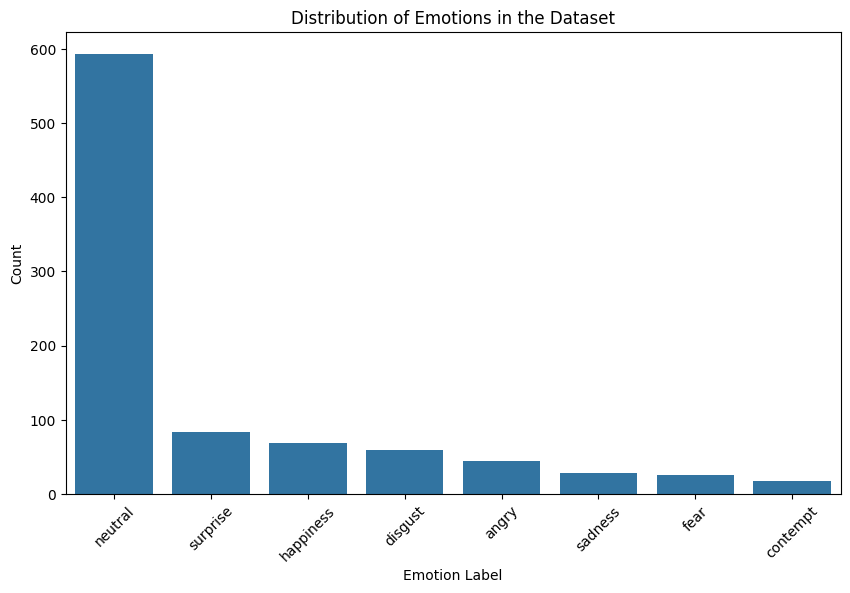


Sample image:


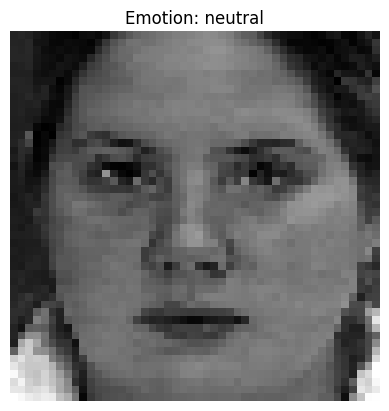


Experiment with following params:
	HOG Parameters: {'win_size': (48, 48), 'block_size': (16, 16), 'block_stride': (8, 8), 'cell_size': (8, 8), 'nbins': 9}
	LBP Parameters: {'radius': 1, 'n_points': 8, 'method': 'uniform'}
	Texture Parameters: {'distances': [1], 'angles': [0, 0.7853981633974483, 1.5707963267948966, 2.356194490192345], 'props': ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']}

	Accuracy: 0.7989
	F1-score: 0.7327
	Sensitivity: 0.3857

Experiment with following params:
	HOG Parameters: {'win_size': (48, 48), 'block_size': (16, 16), 'block_stride': (8, 8), 'cell_size': (8, 8), 'nbins': 9}
	LBP Parameters: {'radius': 1, 'n_points': 8, 'method': 'uniform'}
	Texture Parameters: {'distances': [2], 'angles': [0, 0.7853981633974483, 1.5707963267948966, 2.356194490192345], 'props': ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']}

	Accuracy: 0.8098
	F1-score: 0.7459
	Sensitivity: 0.4022

Experiment with following params:
	HOG Parameters

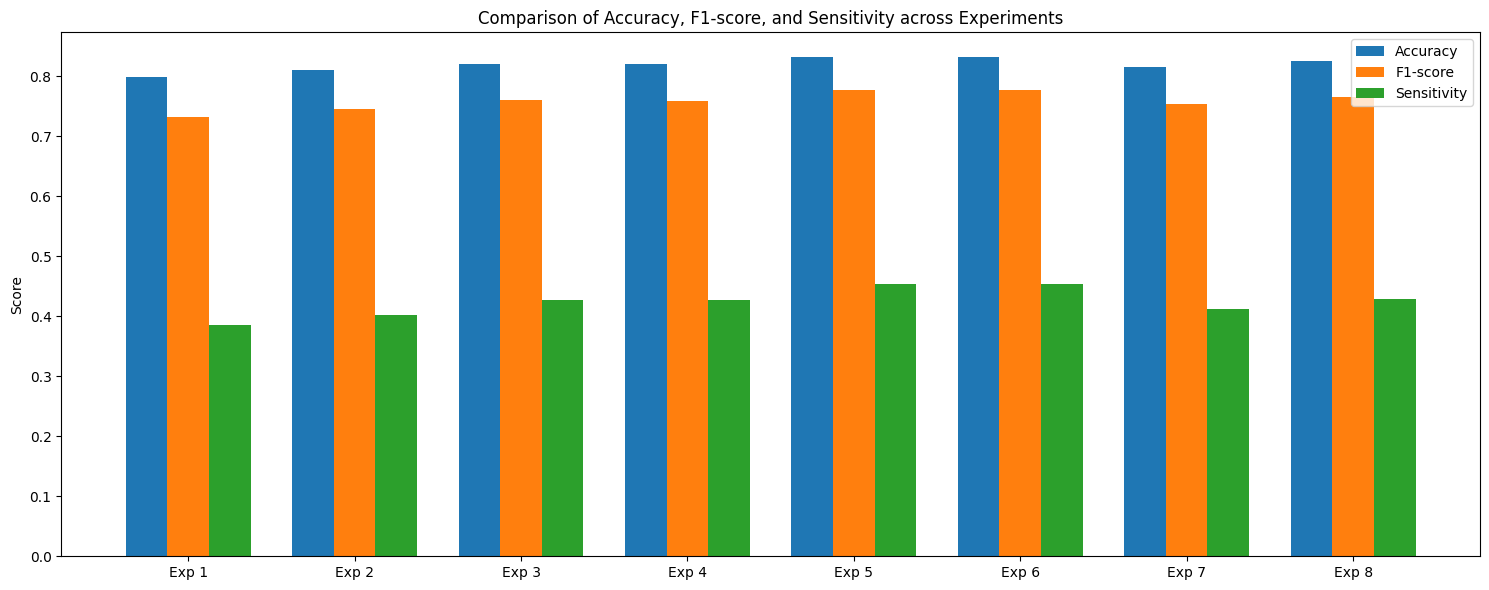

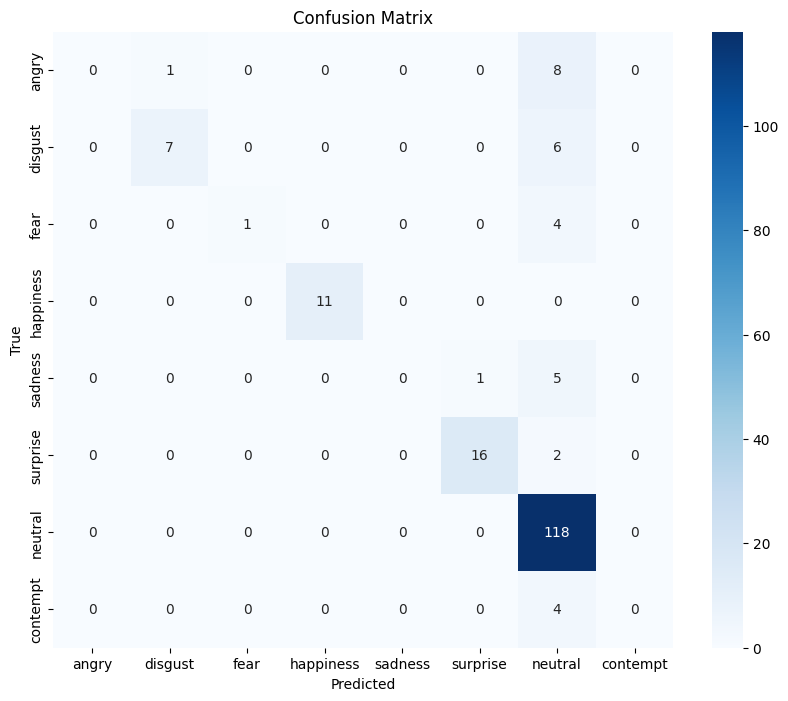


Classification Report for Best Result:
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00         9
     disgust       0.88      0.54      0.67        13
        fear       1.00      0.20      0.33         5
   happiness       1.00      1.00      1.00        11
     sadness       0.00      0.00      0.00         6
    surprise       0.94      0.89      0.91        18
     neutral       0.80      1.00      0.89       118
    contempt       0.00      0.00      0.00         4

    accuracy                           0.83       184
   macro avg       0.58      0.45      0.48       184
weighted avg       0.76      0.83      0.78       184


-------------------------------------------------------------------


In [ ]:
def main():
    try:

        # Dataset Path (download the ck+ dataset csv file in /content dir of colab)
        dataset_path = 'ckextended.csv'

        # Assign labels according to loaded dataset
        if 'ck' in dataset_path:
            label_to_emotion = {
                0: 'angry',
                1: 'disgust',
                2: 'fear',
                3: 'happiness',
                4: 'sadness',
                5: 'surprise',
                6: 'neutral',
                7: 'contempt'
              }
            print('---------------CK+ Extended Dataset loaded-----------')
        else:
          print('No Such dataset can be process with this pipeline or check dataset path is correct')
          return

        # Load dataset
        data = pd.read_csv(dataset_path)

        emotion_labels = list(label_to_emotion.values())

        # Perform EDA
        perform_eda(data, label_to_emotion)

        # data generation for classifier and feature extracion
        X, y = load_dataset(data)

        # Initialize face landmark predictor
        predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

        # Define parameter settings for feature extraction
        hog_params_list = [
            {'win_size': (48, 48), 'block_size': (16, 16), 'block_stride': (8, 8), 'cell_size': (8, 8), 'nbins': 9},
            {'win_size': (64, 64), 'block_size': (32, 32), 'block_stride': (16, 16), 'cell_size': (16, 16), 'nbins': 9},
        ]

        lbp_params_list = [
            {'radius': 1, 'n_points': 8, 'method': 'uniform'},
            {'radius': 2, 'n_points': 16, 'method': 'uniform'},
        ]

        texture_params_list = [
            {'distances': [1], 'angles': [0, np.pi/4, np.pi/2, 3*np.pi/4], 'props': ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']},
            {'distances': [2], 'angles': [0, np.pi/4, np.pi/2, 3*np.pi/4], 'props': ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']},
        ]

        results = []

        # Run experiments with different parameter combinations
        for hog_params in hog_params_list:
            for lbp_params in lbp_params_list:
                for texture_params in texture_params_list:
                    print(f"\nExperiment with following params:")
                    print(f"\tHOG Parameters: {hog_params}")
                    print(f"\tLBP Parameters: {lbp_params}")
                    print(f"\tTexture Parameters: {texture_params}")

                    result = run_experiment(X, y, predictor, hog_params, lbp_params, texture_params)
                    result.update({
                        'hog_params': hog_params,
                        'lbp_params': lbp_params,
                        'texture_params': texture_params
                    })
                    results.append(result)

                    print(f"\n\tAccuracy: {result['accuracy']:.4f}")
                    print(f"\tF1-score: {result['f1_score']:.4f}")
                    print(f"\tSensitivity: {result['sensitivity']:.4f}")


        if len(results) == 0:
          print("No successful experiments. Exiting.")
          return

        # Find best result
        best_result = max(results, key=lambda x: x['accuracy'])

        # Generate report
        print("\n--- Feature Extraction Parameter Experiment Report ---")
        print(f"\tNumber of experiments: {len(results)}")
        print(f"\tBest accuracy achieved: {best_result['accuracy']:.4f}")
        print("\tBest parameters:")
        for key in ['hog_params', 'lbp_params', 'texture_params']:
            print(f"\t  {key}: {best_result[key]}")

        # Calculate overall best sensitivity
        best_sensitivity = max(results, key=lambda x: x['sensitivity'])['sensitivity']
        print(f"\tOverall best sensitivity: {best_sensitivity:.4f}")

        best_f1_score = max(results, key=lambda x: x['f1_score'])['f1_score']
        print(f"\tOverall best F1-score: {best_f1_score:.4f}")

        print("\nTop 5 parameter combinations:")
        for i, result in enumerate(sorted(results, key=lambda x: x['accuracy'], reverse=True)[:5], 1):
            print(f"\n{i}. Accuracy: {result['accuracy']:.4f}, F1-score: {result['f1_score']:.4f}, Sensitivity: {result['sensitivity']:.4f}")
            for key in ['hog_params', 'lbp_params', 'texture_params']:
                print(f"   {key}: {result[key]}")

        # Visualize results
        print("\nVisualization of results:")
        plot_metrics_comparison(results)
        plot_confusion_matrix(best_result['y_test'], best_result['y_pred'], emotion_labels)

        # Print classification report for best result
        print("\nClassification Report for Best Result:")
        print(classification_report(best_result['y_test'], best_result['y_pred'], target_names=emotion_labels))

        print(f"\n-------------------------------------------------------------------")

    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")

if __name__ == "__main__":
    main()


#Analysis:
Performance Analysis:
> The best accuracy of 83.15% indicates a strong performance in facial emotion recognition.

> Overall best sensitivity of 0.4534 suggests moderate responsiveness to changes in input.

> Overall best F1-score: 0.7765 suggests a good balance between correctly identifying emotions (precision) and not missing instances of emotions (recall).

Parameter Impact:
* HOG Parameters: The larger window size (64x64) performed better than
smaller one, suggesting that capturing more context in image improves recognition.
* LBP Parameters: A smaller radius and fewer points performed best, indicating that local texture patterns are more informative at a finer scale for this task.
* Texture Parameters: Using a distance of 1 for GLCM calculation was most effective, implying that nearby pixel relationships are most relevant for emotion recognition.

Insights:
* The combination of global (HOG) and local (LBP, texture) features seems to be effective for emotion recognition.
* The best-performing parameters suggest a balance between capturing detailed local information and broader facial structure.
* The moderate sensitivity score indicates that model is reasonably stable but still responsive to input variations.


*Note: Same experimental setup can be used with FER2013 dataset csv (https://huggingface.co/spaces/mxz/emtion/resolve/c697775e0adc35a9cec32bd4d3484b5f5a263748/fer2013.csv )